In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
class Lipschitz_Linear(nn.Module):
    def __init__(self, h, activation = None):
        super(Lipschitz_Linear, self).__init__()
        self.B = 2 ## Upper bound on product of weights norms
        self.lip_reg = 0.0005 ## learning rate on Lip regularisation !
        self.order = float('inf') ### order of L_j norm
        h = h
        self.activation = activation
        layers = []
        self.linear_layers = []
        self.Norm_constraints = torch.rand(len(h) - 1) * self.B
        for layer in range(1,len(h)):
            linear = nn.Linear(h[layer -1], h[layer])
            layers.append(linear)
            layers.append(nn.BatchNorm1d(h[layer], affine=True))
            self.linear_layers.append(linear)
            if activation is not None:
                layers.append(self.activation())
        self.univariate_nn = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.univariate_nn(x)
    
    def compute_constraint_gradient(self):
        self.grads_norm_constraints = []
        prod = torch.prod(self.Norm_constraints)
        for i in range(len(self.Norm_constraints)):
            grad = torch.sum(self.linear_layers[i].weight.grad * (self.linear_layers[i].weight.data / (torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)))) + self.lip_reg * (prod / self.Norm_constraints[i])  * torch.exp(7 * ((prod) - self.B))
            self.grads_norm_constraints.append(grad)

    def upper_lipschitz_bound(self):
        return torch.prod(self.Norm_constraints)

    def update_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.Norm_constraints[i] -= 0.001 * self.grads_norm_constraints[i]
    
    def project_on_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.linear_layers[i].weight.data *= self.Norm_constraints[i] / torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)
    
    def train_enforce_constraints(self):
        self.compute_constraint_gradient()
        self.update_norm_constraints()
        self.project_on_norm_constraints()





In [4]:
class Lipschitz_GRU(nn.Module):
    def __init__(self, in_dim ,hidden, depth = 2, activation = nn.ReLU):
        super(Lipschitz_GRU, self).__init__()
        self.hidden = hidden
        self.depth = depth

        self.B = 2 ## Upper bound on product of weights norms
        self.lip_reg = 0.0005 ## learning rate on Lip regularisation !
        self.order = float('inf') ### order of L_j norm
        self.activation = activation
        self.Norm_constraints = torch.rand(self.depth) * self.B
        self.gru = nn.GRU(in_dim, self.hidden, num_layers = self.depth, batch_first=True)
        
    def forward(self, x):
        out, self.hidden_state = self.gru(x, self.hidden_state)
        return out
    
    def init_hidden(self, batch_size):
        self.hidden_state = torch.zeros(self.depth, batch_size, self.hidden)
    
    def compute_constraint_gradient(self):
        self.grads_norm_constraints = []
        prod = torch.prod(self.Norm_constraints)
        for i in range(len(self.Norm_constraints)):
            grad = torch.sum(self.linear_layers[i].weight.grad * (self.linear_layers[i].weight.data / (torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)))) + self.lip_reg * (prod / self.Norm_constraints[i])  * torch.exp(7 * ((prod) - self.B))
            self.grads_norm_constraints.append(grad)

    def upper_lipschitz_bound(self):
        return torch.prod(self.Norm_constraints)

    def update_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.Norm_constraints[i] -= 0.001 * self.grads_norm_constraints[i]
    
    def project_on_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.linear_layers[i].weight.data *= self.Norm_constraints[i] / torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)
    
    def train_enforce_constraints(self):
        self.compute_constraint_gradient()
        self.update_norm_constraints()
        self.project_on_norm_constraints()





In [73]:
test = Lipschitz_GRU(in_dim = 1, hidden = 3)
test.init_hidden(32)
output = test(torch.randn(32,1,1))
target = torch.randn(32,1,3)
criterion = nn.MSELoss()
loss = criterion(output, target)
loss.backward()
test.gru.weight_ih_l0.grad

tensor([[-5.0901e-04],
        [-6.0729e-04],
        [ 1.5966e-05],
        [ 4.4473e-03],
        [ 2.8996e-03],
        [ 1.6401e-04],
        [-7.9518e-04],
        [ 1.1130e-02],
        [-1.6209e-03]])

In [98]:
steps = 10
class KAN_RNN_Layer(nn.Module):
    def __init__(self, N_Agents, in_dim, hidden, depth):
        """ 
        in_dim:Dimension of Agent information, i.e cartesian coordinates R^2
        """
        super(KAN_RNN_Layer, self).__init__()
        self.N_Agents = N_Agents
        self.in_dim = in_dim
        self.hidden = hidden 
        self.Network_stack = nn.ModuleList()
        self.linear_Network_stack = nn.ModuleList()
        self.activation = nn.ReLU()
        self.num_forward_steps = steps
        for _ in range(self.N_Agents):
            Networks = nn.ModuleList()
            for _ in range(self.N_Agents):
                Networks.append(Lipschitz_GRU(in_dim = self.in_dim ,hidden = self.hidden, depth = depth)) ## Dimension of input x -> indim, depth number of stacked Gru Layers, hidden Numer of Neurons in the GRu Layers
            self.Network_stack.append(Networks)
            self.linear_Network_stack.append(Lipschitz_Linear([N_Agents * hidden, self.in_dim]))

    def time_step(self, x):
        outs = torch.zeros_like(x)
        for i in range(self.N_Agents): ## out
            output_list = []
            for j in range(self.N_Agents): ### in
                output_list.append(self.Network_stack[i][j](x[:,j,:].unsqueeze(1)))
            out = self.linear_Network_stack[i](self.activation(torch.cat(output_list, dim=1).reshape(-1, self.N_Agents * self.hidden)))
            outs[:,i,:] = out
        return outs

    def system_dynamics(self,u, x_prev):
        lam = 0.5
        return x_prev + lam * u

    def forward(self, x):
        """
        x: Inital States [Batch_size, N_Agents, in_dim] 

        return 
        control_trajectory: controller output [Num_timesteps ,Batch_size, N_Agents, in_dim]
        outs: State of Agents [Num_timesteps ,Batch_size, N_Agents, in_dim]  

        """ 
        outs = torch.zeros(self.num_forward_steps, *x.shape)
        control_trajectory = torch.zeros(self.num_forward_steps, *x.shape) ## Assume u of same shape as x!
        for i in range(self.num_forward_steps):
            outs[i] = x
            u = self.time_step(x)
            x = self.system_dynamics(u, x)
            control_trajectory[i] = u
        return outs, control_trajectory


    def init_hidden(self, batch_size):
        for lists in self.Network_stack:
            for gru in lists:
                gru.init_hidden(batch_size)

    def train_enforce_constraints(self):
        Lip_lin.train_enforce_constraints()
        self.fc2.train_enforce_constraints()

         


In [101]:
N_Agents = 4
batch_size = 32
in_dim = 1
n_samples = 100
def gen_sample():
    X = torch.randn(batch_size,N_Agents, in_dim) 
    return X, X.unsqueeze(0).repeat(steps - 1, 1, 1, 1)


In [104]:
model = KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 16, depth = 2)
model.init_hidden(batch_size = batch_size)

Epoch [1/500], Loss: 0.0390
Epoch [2/500], Loss: 0.0281
Epoch [3/500], Loss: 0.0214
Epoch [4/500], Loss: 0.0158
Epoch [5/500], Loss: 0.0131
Epoch [6/500], Loss: 0.0108
Epoch [7/500], Loss: 0.0087
Epoch [8/500], Loss: 0.0078
Epoch [9/500], Loss: 0.0052
Epoch [10/500], Loss: 0.0043
Epoch [11/500], Loss: 0.0053
Epoch [12/500], Loss: 0.0029
Epoch [13/500], Loss: 0.0036
Epoch [14/500], Loss: 0.0032
Epoch [15/500], Loss: 0.0030
Epoch [16/500], Loss: 0.0031
Epoch [17/500], Loss: 0.0031
Epoch [18/500], Loss: 0.0024
Epoch [19/500], Loss: 0.0027
Epoch [20/500], Loss: 0.0020
Epoch [21/500], Loss: 0.0022
Epoch [22/500], Loss: 0.0026
Epoch [23/500], Loss: 0.0020
Epoch [24/500], Loss: 0.0026
Epoch [25/500], Loss: 0.0024
Epoch [26/500], Loss: 0.0020
Epoch [27/500], Loss: 0.0031
Epoch [28/500], Loss: 0.0026
Epoch [29/500], Loss: 0.0019
Epoch [30/500], Loss: 0.0015
Epoch [31/500], Loss: 0.0032
Epoch [32/500], Loss: 0.0020
Epoch [33/500], Loss: 0.0018
Epoch [34/500], Loss: 0.0015
Epoch [35/500], Loss: 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [500/500], Loss: 0.0020


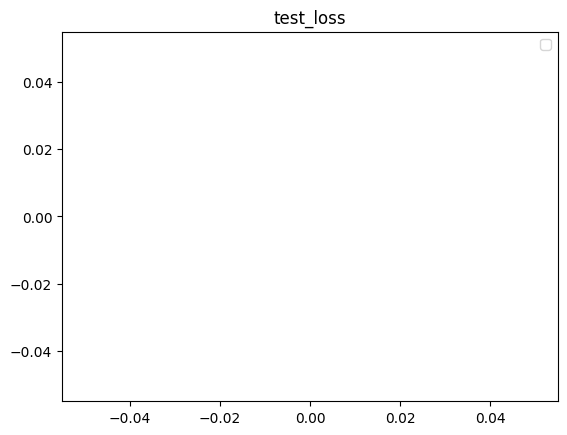

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


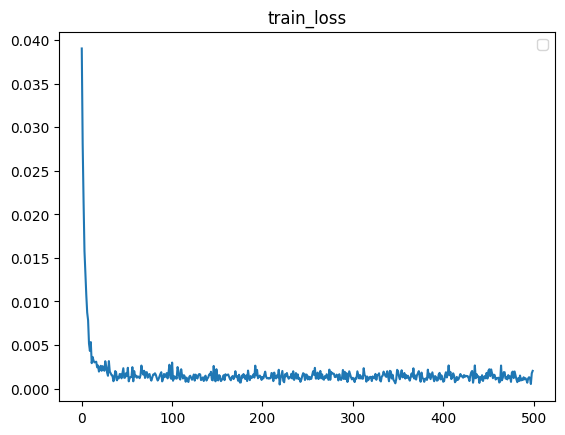

Training Complete!


In [105]:
epochs = 500  # Number of epochs to train
criterion = nn.MSELoss(reduction='mean')  # Mean Squared Error Loss
criterion_test = nn.MSELoss(reduction='sum')  # Mean Squared Error Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        #print(inputs.shape, targets.shape)
        inputs, targets = gen_sample()
        _, outputs = model(inputs)
        #print(outputs.shape)
        loss = criterion(outputs[1:,:,:,:], targets)
        loss.backward()
        optimizer.step()
        #print("did one step")
        #model.train_enforce_constraints()
        running_loss += loss.item()
    avg_loss = running_loss / n_samples
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
plt.plot(test_loss)
plt.title('test_loss')
plt.legend()
plt.show()
plt.plot(train_loss)
plt.title('train_loss')
plt.legend()
plt.show()
print("Training Complete!")

tensor([[[-0.5733, -1.1735],
         [-0.2110,  1.3537],
         [-0.8912,  0.4967],
         [ 1.6755, -0.6769]],

        [[-1.0037, -0.9008],
         [ 1.1723,  1.1508],
         [ 0.8098,  0.8319],
         [-0.9783, -1.0819]],

        [[-0.7334, -0.4555],
         [ 1.3093, -0.9915],
         [ 0.6001,  1.6201],
         [-1.1761, -0.1730]],

        [[-0.2924,  0.0295],
         [-1.2782,  0.0803],
         [ 0.0702, -1.4653],
         [ 1.5005,  1.3555]]], grad_fn=<CopySlices>)
tensor([[[ 0.0798, -0.9756],
         [-0.8564,  1.3121],
         [-0.8203,  0.6041],
         [ 1.5969, -0.9406]],

        [[-0.9404, -0.9134],
         [ 1.1987,  1.1471],
         [ 0.7762,  0.8373],
         [-1.0345, -1.0710]],

        [[-0.5329,  1.6368],
         [ 1.3360, -0.9537],
         [ 0.4941, -0.0795],
         [-1.2972, -0.6036]],

        [[ 0.2098, -0.1779],
         [-1.4176, -0.1371],
         [-0.1664, -1.2360],
         [ 1.3742,  1.5510]]], grad_fn=<CopySlices>)
tensor([[[ 0